In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
%matplotlib inline

In [2]:
with open('predictions.pickle', 'rb') as f:
    X, feature_names, n_features, n_samples, indices, pred_a, pred_b, proba_a, proba_b, log_proba_a, log_proba_b, log_odds_a, log_odds_b = pickle.load(f)

In [3]:
try:
    with open('subsets.pickle', 'rb') as f:
        is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff = pickle.load(f)
        print('Loaded cached subsets')
except FileNotFoundError:
    print('No cached subsets found')

No cached subsets found


### Differences of predicted labels

First, let's see to what extent the predicted labels are different:

In [4]:
is_pred_diff = pred_a != pred_b
np.sum(is_pred_diff)

381

In how many of these cases does classifier A predict the positive label, and in how many B?

In [5]:
is_pred_diff_a_pos = is_pred_diff & (pred_a == True)
is_pred_diff_b_pos = is_pred_diff & (pred_b == True)
print(f'A predicts positive: {np.sum(is_pred_diff_a_pos)}')
print(f'B predicts positive: {np.sum(is_pred_diff_b_pos)}')

A predicts positive: 184
B predicts positive: 197


What are the predicted probabilities for these instances? They have in common, that they are close to the decision boundary of 50% that enables them to lead to different outcomes

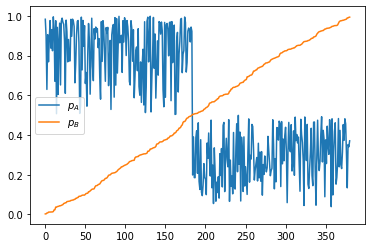

In [6]:
proba_a_subset = proba_a[is_pred_diff, 1]
proba_b_subset = proba_b[is_pred_diff, 1]
order = np.argsort(proba_b_subset)
plt.plot(proba_a_subset[order], label='$p_A$')
plt.plot(proba_b_subset[order], label='$p_B$')
plt.legend();

In margin space, we see that they are close to zero:

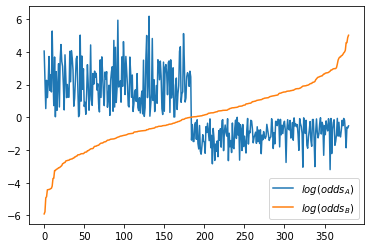

In [7]:
log_odds_a_subset = log_odds_a[is_pred_diff]
log_odds_b_subset = log_odds_b[is_pred_diff]
order = np.argsort(log_odds_b_subset)
plt.plot(log_odds_a_subset[order], label='$log(odds_A)$')
plt.plot(log_odds_b_subset[order], label='$log(odds_B)$')
plt.legend();

### Differences of probabilities

Counting different binary labels is actually the same as counting those with a joint predicted probability of A and B different higher than 50%:

In [8]:
proba_diff_a_pos = proba_a[:, 1] * proba_b[:, 0]
proba_diff_b_pos = proba_a[:, 0] * proba_b[:, 1]
proba_diff = proba_diff_a_pos + proba_diff_b_pos
np.array_equal(proba_diff > 0.5, is_pred_diff)

True

Adding a check we can also find the instances' predictions where either A or B predicts the positive label

In [9]:
np.array_equal((proba_diff > 0.5) & (proba_diff_a_pos > proba_diff_b_pos), is_pred_diff_a_pos)

True

In [10]:
np.array_equal((proba_diff > 0.5) & (proba_diff_a_pos <= proba_diff_b_pos), is_pred_diff_b_pos)

True

What is this composed of? First, the probabilities of A predicting the positive label and B predicting the negative label and vice versa:

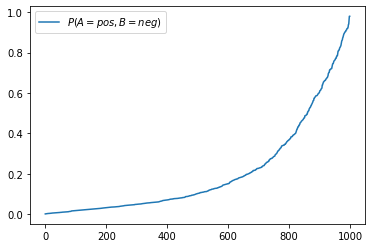

In [11]:
plt.plot(sorted(proba_diff_a_pos), label='$P(A = pos, B = neg)$')
plt.legend();

Note the very small scale of the plot:

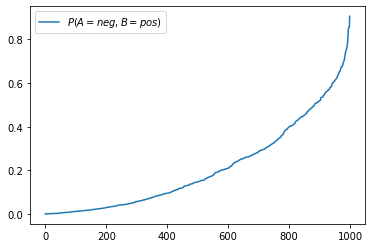

In [12]:
plt.plot(sorted(proba_diff_b_pos), label='$P(A = neg, B = pos)$')
plt.legend();

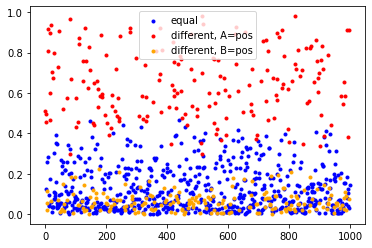

In [13]:
plt.scatter(indices[~is_pred_diff], proba_diff_a_pos[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], proba_diff_a_pos[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], proba_diff_a_pos[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

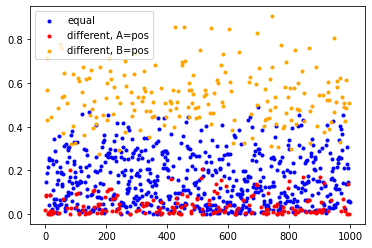

In [14]:
plt.scatter(indices[~is_pred_diff], proba_diff_b_pos[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], proba_diff_b_pos[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], proba_diff_b_pos[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

Subset covers 38.1%


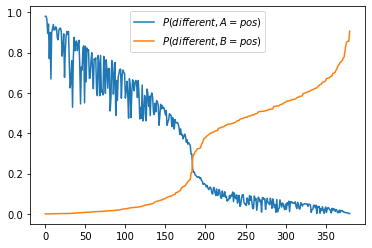

In [15]:
proba_diff_a_pos_subset = proba_diff_a_pos[is_pred_diff]
proba_diff_b_pos_subset = proba_diff_b_pos[is_pred_diff]
order = np.argsort(proba_diff_b_pos_subset)
plt.plot(proba_diff_a_pos_subset[order], label='$P(different,A=pos)$')
plt.plot(proba_diff_b_pos_subset[order], label='$P(different,B=pos)$')
plt.legend();
print(f'Subset covers {round(np.sum(is_pred_diff)/len(is_pred_diff)*100, 2)}%')

The combined probabilities are:

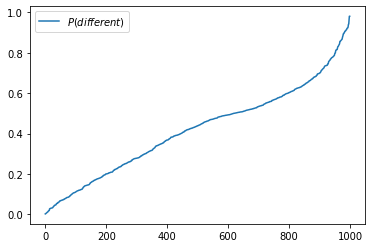

In [16]:
plt.plot(sorted(proba_diff), label='$P(different)$')
plt.legend();

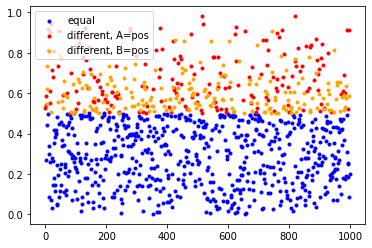

In [17]:
plt.scatter(indices[~is_pred_diff], proba_diff[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], proba_diff[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], proba_diff[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

or we just look at those over 0.5

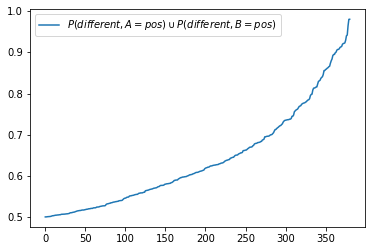

In [18]:
criteria = proba_diff > 0.5
plt.plot(sorted(proba_diff[criteria]), label='$P(different, A=pos) \cup P(different, B=pos)$')
plt.legend();

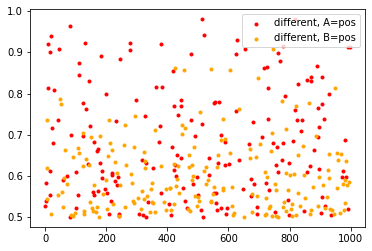

In [19]:
plt.scatter(indices[criteria & is_pred_diff_a_pos], proba_diff[criteria & is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[criteria & is_pred_diff_b_pos], proba_diff[criteria & is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

Comparing a classifier to itself, we get the uncertainty of a classifier

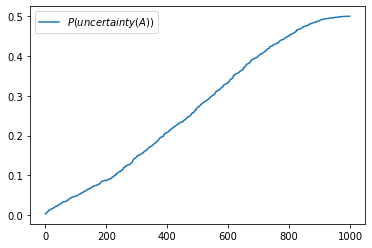

In [20]:
proba_uncert_a = proba_a[:, 1] * proba_a[:, 0]
proba_uncert_b = proba_b[:, 1] * proba_b[:, 0]
plt.plot(sorted(2 * proba_uncert_a), label='$P(uncertainty(A))$')
plt.legend();

Removing this, we get the following

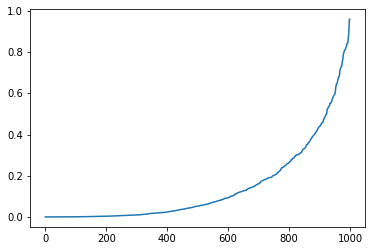

In [21]:
proba_diff_wo_uncert = proba_diff - (proba_uncert_a + proba_uncert_b)
plt.plot(sorted(proba_diff_wo_uncert));

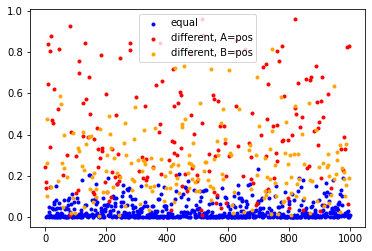

In [22]:
plt.scatter(indices[~is_pred_diff], proba_diff_wo_uncert[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], proba_diff_wo_uncert[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], proba_diff_wo_uncert[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

We can look at the euclidian distance between pairs of probabilities $|p_B - p_A|$, but this does not correlate with the observations that actually have different predicted labels

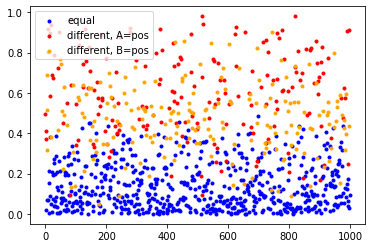

In [23]:
euclid_dist_proba = np.abs(proba_b[:, 1] - proba_a[:, 1])
plt.scatter(indices[~is_pred_diff], euclid_dist_proba[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], euclid_dist_proba[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], euclid_dist_proba[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

And further subtractions:

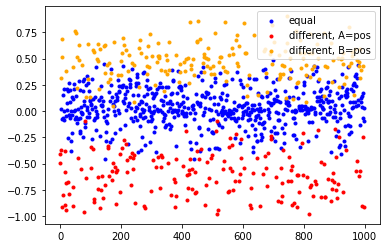

In [24]:
sub_proba = proba_b[:, 1] - proba_a[:, 1]
plt.scatter(indices[~is_pred_diff], sub_proba[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], sub_proba[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], sub_proba[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

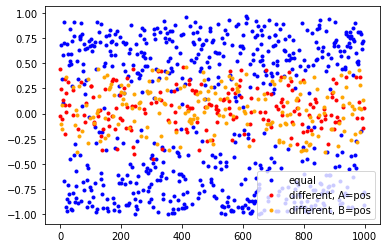

In [25]:
sub_compl_proba = proba_b[:, 1] - proba_a[:, 0]
plt.scatter(indices[~is_pred_diff], sub_compl_proba[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], sub_compl_proba[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], sub_compl_proba[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

[Here](https://en.wikipedia.org/wiki/Metric_space#Examples_of_metric_spaces) is another distance function proposed $|log(\frac{p_B}{p_A})|$ that forms a complete metric space for real positive numbers

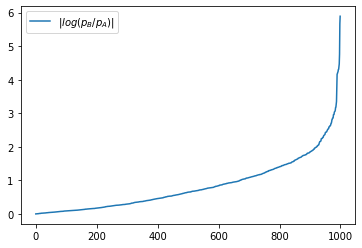

In [26]:
log_proba_ratio = np.abs(np.log(proba_b[:, 1]/proba_a[:, 1]))
plt.plot(sorted(log_proba_ratio), label='$|log(p_B/p_A)|$')
plt.legend();

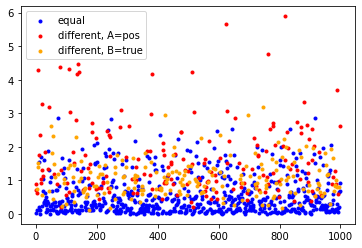

In [27]:
plt.scatter(indices[~is_pred_diff], log_proba_ratio[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], log_proba_ratio[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], log_proba_ratio[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=true')
plt.legend();

### Differences of log odds
Now let's see how that looks like in margin space

In [28]:
log_proba_diff_a_pos = log_proba_a[:, 1] + log_proba_b[:, 0]
log_proba_diff_b_pos = log_proba_a[:, 0] + log_proba_b[:, 1]

log_proba_add = lambda x, y: x + np.log1p(np.exp(y - x))
log_proba_diff = log_proba_add(log_proba_diff_a_pos, log_proba_diff_b_pos)

log_proba_complement = lambda x: np.log1p(-np.exp(x))
log_proba_to_log_odds = lambda x: x - log_proba_complement(x)
log_odds_diff_a_pos = log_proba_to_log_odds(log_proba_diff_a_pos)
log_odds_diff_b_pos = log_proba_to_log_odds(log_proba_diff_b_pos)
log_odds_diff = log_proba_to_log_odds(log_proba_diff)

In [29]:
np.array_equal(log_odds_diff > 0, is_pred_diff)

True

In [30]:
np.array_equal((log_odds_diff > 0) & (log_odds_diff_a_pos > log_odds_diff_b_pos), is_pred_diff_a_pos)

True

In [31]:
np.array_equal((log_odds_diff > 0) & (log_odds_diff_a_pos <= log_odds_diff_b_pos), is_pred_diff_b_pos)

True

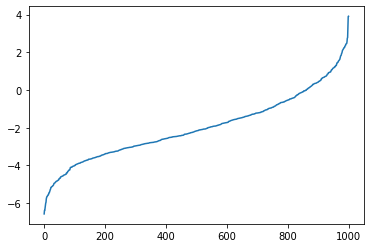

In [32]:
plt.plot(sorted(log_odds_diff_a_pos));

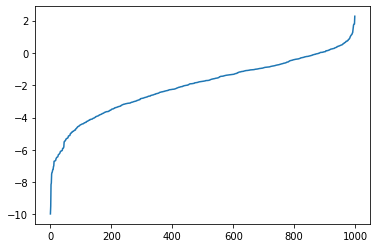

In [33]:
plt.plot(sorted(log_odds_diff_b_pos));

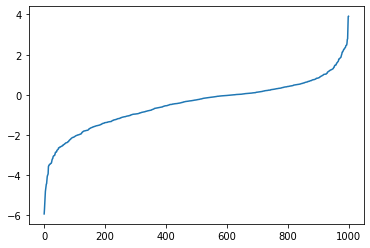

In [34]:
plt.plot(sorted(log_odds_diff));

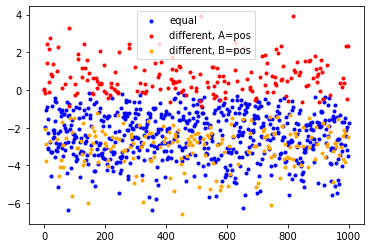

In [35]:
plt.scatter(indices[~is_pred_diff], log_odds_diff_a_pos[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], log_odds_diff_a_pos[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], log_odds_diff_a_pos[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

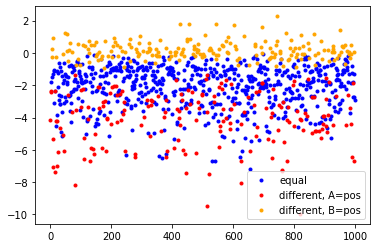

In [36]:
plt.scatter(indices[~is_pred_diff], log_odds_diff_b_pos[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], log_odds_diff_b_pos[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], log_odds_diff_b_pos[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

Subset covers 38.1%


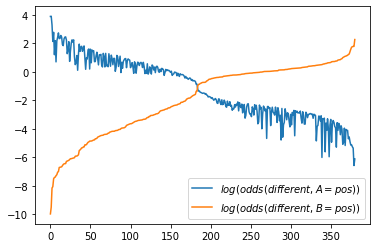

In [37]:
log_odds_diff_a_pos_subset = log_odds_diff_a_pos[is_pred_diff]
log_odds_diff_b_pos_subset = log_odds_diff_b_pos[is_pred_diff]
order = np.argsort(log_odds_diff_b_pos_subset)
plt.plot(log_odds_diff_a_pos_subset[order], label='$log(odds(different,A=pos))}$')
plt.plot(log_odds_diff_b_pos_subset[order], label='$log(odds(different,B=pos))$')
plt.legend();
print(f'Subset covers {round(np.sum(is_pred_diff)/len(is_pred_diff)*100, 2)}%')

The combined probabilities are:

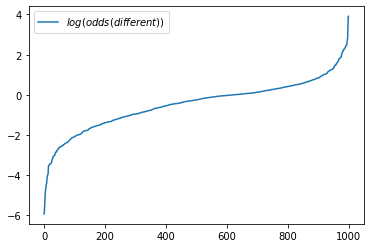

In [38]:
plt.plot(sorted(log_odds_diff), label='$log(odds(different))$')
plt.legend();

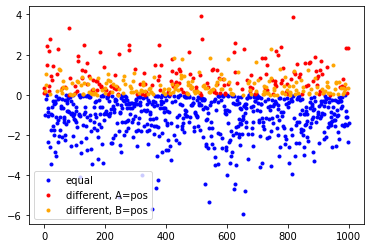

In [39]:
plt.scatter(indices[~is_pred_diff], log_odds_diff[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], log_odds_diff[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], log_odds_diff[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

or we just look at those over 0.

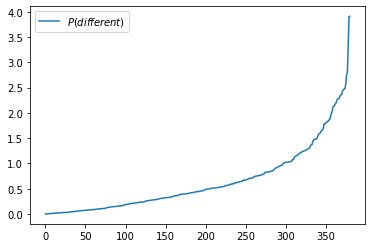

In [40]:
criteria = log_odds_diff > 0
plt.plot(sorted(log_odds_diff[criteria]), label='$P(different)$')
plt.legend();

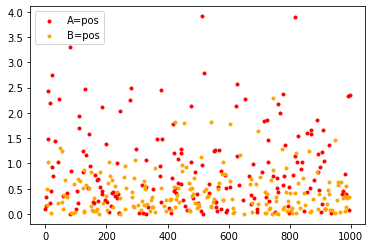

In [41]:
plt.scatter(indices[criteria & is_pred_diff_a_pos], log_odds_diff[criteria & is_pred_diff_a_pos], c='red', marker='.', label='A=pos')
plt.scatter(indices[criteria & is_pred_diff_b_pos], log_odds_diff[criteria & is_pred_diff_b_pos], c='orange', marker='.', label='B=pos')
plt.legend();

We can look at the euclidian distance between pairs of probabilities $|p_B - p_A|$, but this does not correlate with the observations that actually have different predicted labels

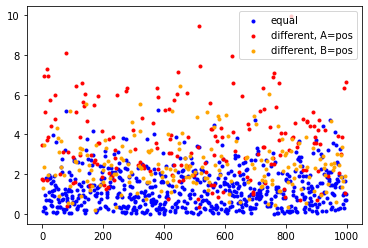

In [42]:
euclid_dist_proba = np.abs(log_odds_b - log_odds_a)
plt.scatter(indices[~is_pred_diff], euclid_dist_proba[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], euclid_dist_proba[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], euclid_dist_proba[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

Next, there is the log of odds ratio, and the closely related euclidian distance in margin space

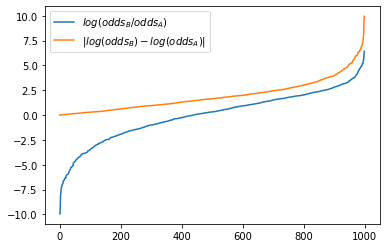

In [43]:
log_odds_ratio = log_odds_b - log_odds_a
euclid_dist_log_odds = np.sqrt(np.square(log_odds_ratio))
plt.plot(sorted(log_odds_ratio), label='$log(odds_B / odds_A)$')
plt.plot(sorted(euclid_dist_log_odds), label='$|log(odds_B) - log(odds_A)|$')
plt.legend();

But it too does not relate well to the observed differences in predicted labels

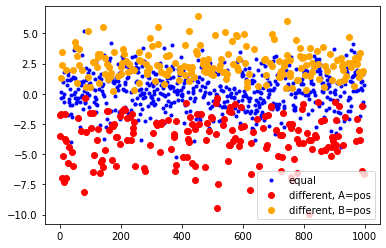

In [44]:
plt.scatter(indices[~is_pred_diff], log_odds_ratio[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], log_odds_ratio[is_pred_diff_a_pos], c='red', marker='o', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], log_odds_ratio[is_pred_diff_b_pos], c='orange', marker='o', label='different, B=pos')
plt.legend();

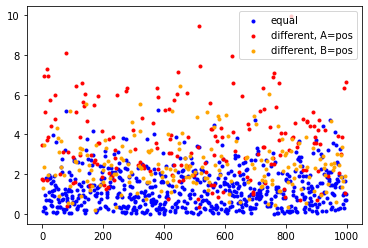

In [45]:
plt.scatter(indices[~is_pred_diff], euclid_dist_log_odds[~is_pred_diff], c='blue', marker='.', label='equal')
plt.scatter(indices[is_pred_diff_a_pos], euclid_dist_log_odds[is_pred_diff_a_pos], c='red', marker='.', label='different, A=pos')
plt.scatter(indices[is_pred_diff_b_pos], euclid_dist_log_odds[is_pred_diff_b_pos], c='orange', marker='.', label='different, B=pos')
plt.legend();

### Extending the subset to be explained

Instances with a predicted probability of different outcomes close to 0.5 have a high potential to flip

They are either one of:
- instance where one of the classifiers is uncertain ( $p_C$ close to 0.5), doesn't matter if the other classifier is pretty certain in its prediction or not, since the prediction of the uncertain classifier could easily flip
- instance where one classifier predicts a high probability for the positive class and the other a high probability for the negative class

So I need to investigate:
1. The subset where the predicted labels are different
2. The subset of instances, where predicted labels are equal but the probability is high that one of the classifiers flips the predicted label
3. The other instances, to contrast the findings

For (2.), I will sample from the instances whose predicted probability for different predicted labels is between 0.25 and 0.5, because when taking a look at the predicted probabilities of different predicted labels where A predicted positive the actual different instances were close around 0.25, and I argue, that at least one of them needs to be close to 0.25 before being added up.

358

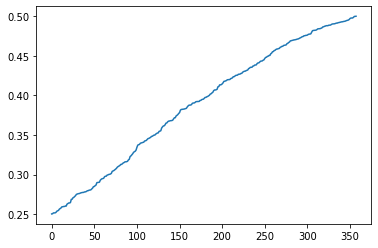

In [46]:
is_high_proba_diff = (0.25 <= proba_diff) & (proba_diff < 0.5)
plt.plot(sorted(proba_diff[is_high_proba_diff]))
np.sum(is_high_proba_diff)

261

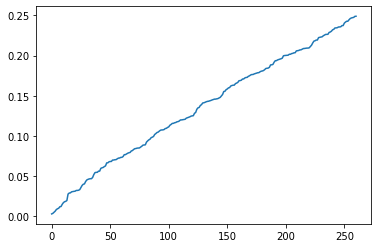

In [47]:
is_low_proba_diff = proba_diff < 0.25
plt.plot(sorted(proba_diff[is_low_proba_diff]))
np.sum(is_low_proba_diff)

In [48]:
with open('subsets.pickle', 'wb') as f:
    pickle.dump((is_pred_diff, is_pred_diff_a_pos, is_pred_diff_b_pos, proba_diff_a_pos, proba_diff_b_pos, proba_diff, log_odds_diff_a_pos, log_odds_diff_b_pos, log_odds_diff), f, pickle.HIGHEST_PROTOCOL)